In [ ]:


import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load the dataset
data = pd.read_excel('songdata.xlsx', sheet_name='Sheet1')

# Display the first few rows of the dataset
data.head()


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [5]:
# Remove rows with missing or null values in important columns
data = data.dropna(subset=['track_name', 'popularity', 'duration_ms', 'danceability', 
                           'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
                           'instrumentalness', 'liveness', 'valence', 'tempo', 'track_genre'])

# Remove duplicates
data = data.drop_duplicates(subset=['track_name'])

# Check for any missing values after cleaning
data.isnull().sum()


track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [15]:
# Define a function to assign mood based on valence, energy, and danceability
def assign_mood(row):
    mood_score = row['valence'] * 0.4 + row['energy'] * 0.4 + row['danceability'] * 0.2
    if mood_score > 0.9:
        return 'Happiness'
    elif mood_score > 0.75:
        return 'Pleasant Surprise'
    elif mood_score > 0.6:
        return 'Neutral'
    elif mood_score > 0.5:
        return 'Disgust'
    elif mood_score > 0.4:
        return 'Sadness'
    elif mood_score > 0.3:
        return 'Fear'
    elif mood_score > 0.2:
        return 'Anger'
    else:
        return 'Melancholic'

data['mood'] = data.apply(assign_mood, axis=1)

# Check the newly added mood column
data[['track_name', 'mood']].head()


,track_name,mood
0,Comedy,Pleasure
1,Ghost - Acoustic,Gloomy
2,To Begin Again,Gloomy
3,Can't Help Falling In Love,Downcast
4,Hold On,Disappointed


In [7]:
# Select relevant features for the model
features = ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 
            'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X = data[features]
y = data['mood']

# Normalize the feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the scaled features
X_scaled[:5]


array([[ 1.39393253, -0.02003673,  0.4938806 , -0.53889163, -1.18238675,
         0.43085998,  0.14248582, -1.07415167, -0.50252198,  0.67460315,
         0.91487014, -0.93209752],
       [ 0.62118635, -0.6586376 , -0.91929869, -1.68178089, -1.18238675,
        -1.24111478, -0.21254497,  1.52571652, -0.50250741, -0.57419413,
        -0.79537787, -1.27275983],
       [ 0.70704704, -0.17634645, -0.81993453, -0.93406012, -1.46319925,
        -0.04543524, -0.32219466, -0.5558106 , -0.50252522, -0.49644799,
        -1.356553  , -1.31055676],
       [ 1.30807185, -0.24641008, -1.76941436, -2.09399587, -1.46319925,
        -1.44515021, -0.42545699,  1.47032574, -0.50229883, -0.42356099,
        -1.26875009,  2.13291595],
       [ 1.78030562, -0.27067591,  0.17370717, -0.60862725, -0.90157425,
        -0.0369869 , -0.33869534,  0.19925316, -0.50252522, -0.66214444,
        -1.17712966,  0.11432512]])

C:\Users\Vishwesh PC\AppData\Local\Temp\ipykernel_21600\870803452.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='mood', palette='viridis')


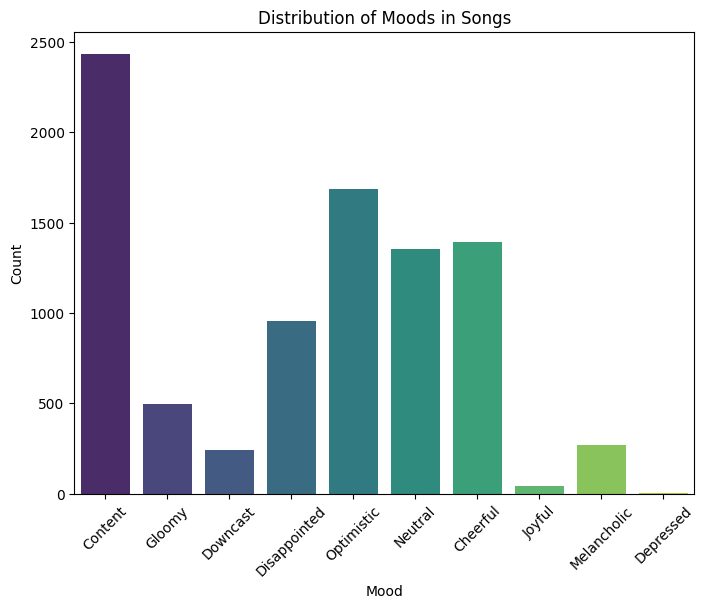

In [8]:
# Count plot to visualize the distribution of moods in the dataset
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='mood', palette='viridis')
plt.title('Distribution of Moods in Songs')
plt.xlabel('Mood')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


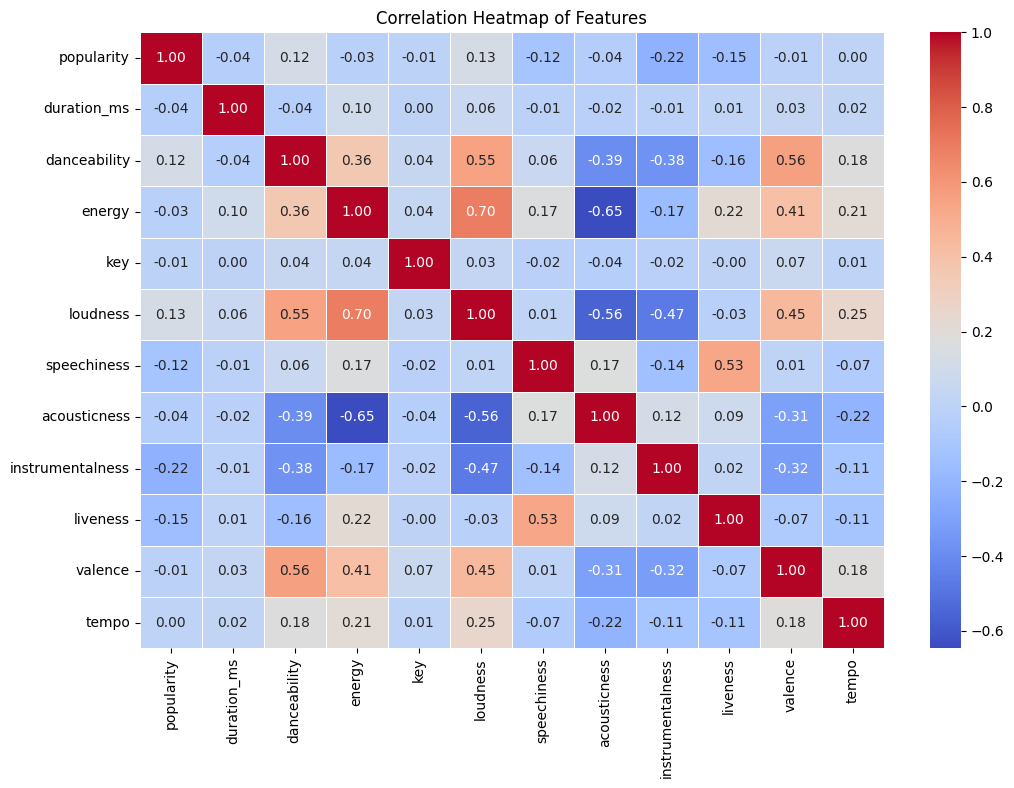

In [9]:
# Plot a heatmap to visualize the correlation between the numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = data[['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 
                           'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.show()


In [10]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Cross-Validation Accuracy (5-fold cross-validation)
cv_scores = cross_val_score(rf_model, X_scaled, y, cv=5)
print(f"Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%")


c:\Users\Vishwesh PC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vishwesh PC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vishwesh PC\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vishwesh PC\.venv\Lib\sit

Classification Report:
               precision    recall  f1-score   support

    Cheerful       0.91      0.90      0.90       268
     Content       0.91      0.92      0.91       512
   Depressed       0.00      0.00      0.00         1
Disappointed       0.86      0.91      0.89       196
    Downcast       0.84      0.86      0.85        42
      Gloomy       0.90      0.81      0.86        91
      Joyful       1.00      0.10      0.18        10
 Melancholic       0.98      0.94      0.96        50
     Neutral       0.86      0.85      0.86       264
  Optimistic       0.86      0.88      0.87       341

    accuracy                           0.89      1775
   macro avg       0.81      0.72      0.73      1775
weighted avg       0.89      0.89      0.88      1775

Model Accuracy: 88.68%
Cross-Validation Accuracy: 85.30%


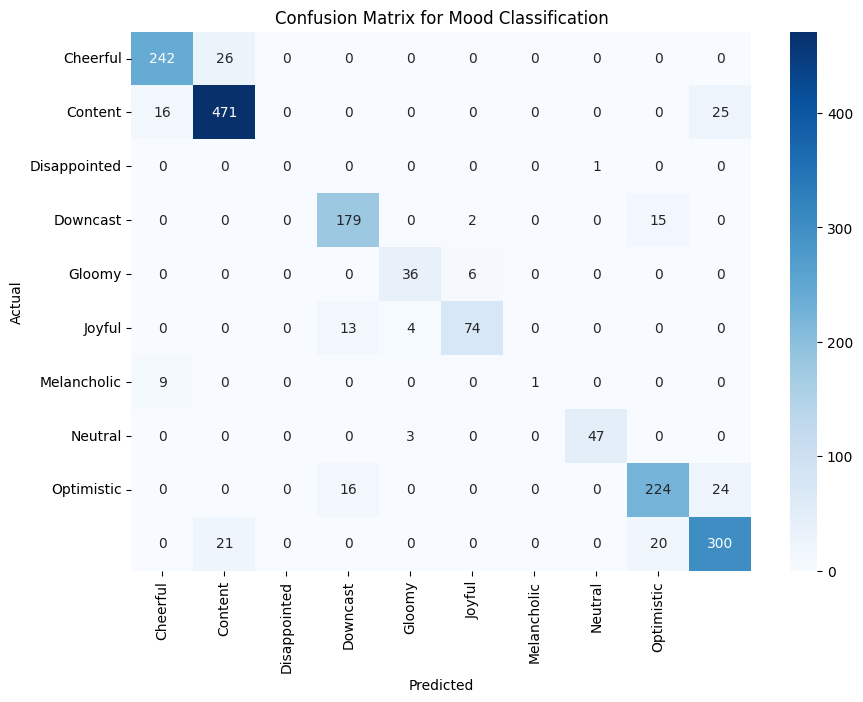

In [11]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix for Mood Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


C:\Users\Vishwesh PC\AppData\Local\Temp\ipykernel_21600\3732139707.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=features, y=feature_importances, palette='viridis')


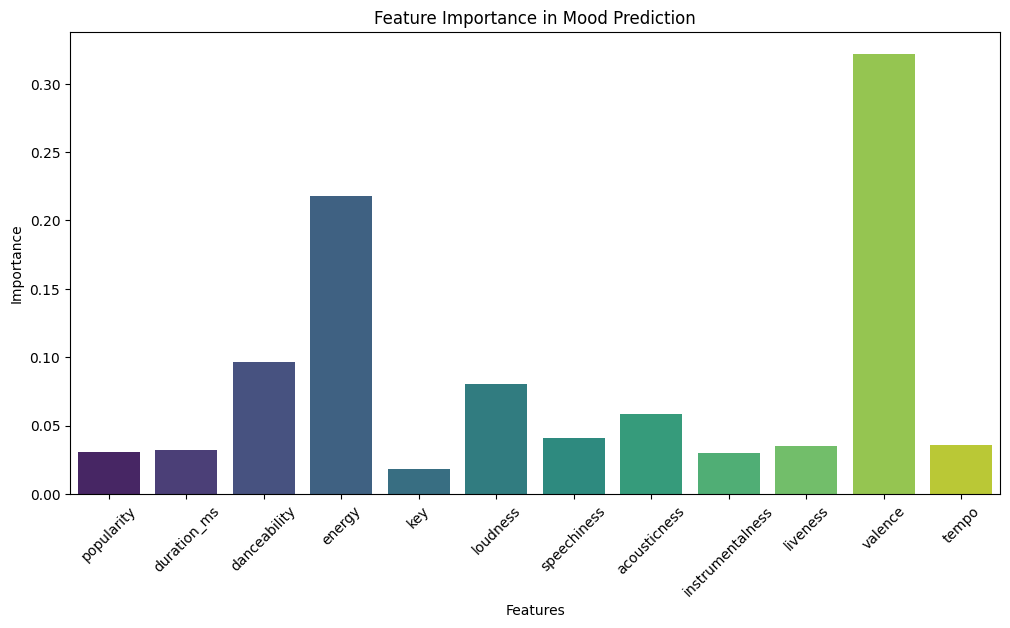

In [12]:
# Get the feature importances from the trained model
feature_importances = rf_model.feature_importances_

# Create a bar plot for feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=features, y=feature_importances, palette='viridis')
plt.title('Feature Importance in Mood Prediction')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()


In [13]:
# Function to recommend songs based on similarity (cosine similarity matrix) with the same mood
def recommend_songs_by_similarity_and_mood(song_name, data, scaler, num_recommendations=5):
    # Find the song index based on the song name
    song_row = data[data['track_name'].str.contains(song_name, case=False, na=False)]
    
    if song_row.empty:
        print("Song not found. Please try again with a valid song name.")
        return
    
    song_id = song_row.index[0]  # Get the index of the song
    song_features = data.loc[song_id, ['popularity', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 
                                       'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']].values.reshape(1, -1)
    
    # Get the mood of the input song
    song_mood = data.loc[song_id, 'mood']
    
    # Print the mood of the input song
    print(f"The mood of the input song '{song_name}' is: {song_mood}")
    
    # Filter songs by the same mood
    mood_filtered_data = data[data['mood'] == song_mood]
    
    if mood_filtered_data.shape[0] <= 1:
        print("Not enough songs with the same mood to recommend.")
        return mood_filtered_data[['track_name', 'track_genre', 'mood']]
    
    # Calculate cosine similarity between the input song and all other songs with the same mood
    mood_filtered_features = mood_filtered_data[features]
    similarity_matrix = cosine_similarity(song_features, scaler.transform(mood_filtered_features))
    
    # Get indices of the most similar songs
    similar_song_indices = similarity_matrix.argsort()[0][-num_recommendations-1:-1][::-1]
    
    # Get the recommended songs and their similarities from the dataset
    recommended_songs = mood_filtered_data.iloc[similar_song_indices]
    recommended_songs.loc[:, 'similarity'] = similarity_matrix[0, similar_song_indices]
    
    return recommended_songs[['track_name', 'track_genre', 'mood', 'similarity']]


In [14]:
# User input for the song name
song_name = input("Enter the song name for recommendations: ")

# Get recommended songs
recommended_songs = recommend_songs_by_similarity_and_mood(song_name, data, scaler)
if recommended_songs is not None:
    print("Recommended Songs based on Similarity and Same Mood with Similarity Scores:\n", recommended_songs)


The mood of the input song 'One Two Three Four' is: Cheerful
Recommended Songs based on Similarity and Same Mood with Similarity Scores:
                             track_name track_genre      mood  similarity
3465              Kandha Sasti Kavasam   classical  Cheerful    0.971867
6059                Akhiyan Udeekdiyan        folk  Cheerful    0.913336
1232                      QuÃ© Sabemos    afrobeat  Cheerful    0.753658
1129              The Moon and The Sun    afrobeat  Cheerful    0.735680
8835  Der ultimative Wendler Hitmix XS       party  Cheerful    0.730142


C:\Users\Vishwesh PC\AppData\Local\Temp\ipykernel_21600\2537308937.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_songs.loc[:, 'similarity'] = similarity_matrix[0, similar_song_indices]
